In [22]:
import astropy.io.ascii as asc
import numpy as np
import emcee
from mpmath import expint, mp
import matplotlib.pyplot as plt

COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14 #12
plt.rcParams['ytick.major.size']  = 14#12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams['axes.linewidth'] = 3
lw = 5

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

parula = np.load('/Users/arcticfox/parula_colors.npy')

In [26]:
def lnp(params, loga):

    # Note: params[0] = q, params[1] = a*                                                                                   
    q = params[0]
    astar = 10.**params[1]

    # Enforce limits to ensure that the normalization remains bounded                                                       
    if q < 0: return -np.inf
    if a0/astar > 100: return -np.inf

    # Compute normalization; note that we need to use mpmath's                                                              
    # implementation of the generalized exponential integral here,                                                          
    # rather than the faster scipy one, because scipy's implementation                                                      
    # does not support non-integral orders                                                                                  
    norm = a0**(q-1) / mp.mpf(expint(q, a0/astar))

    # Compute log likeilhood and return                                                                                     
    return loga.size * mp.log(norm) - q * np.sum(loga) - np.sum(np.exp(loga))/astar

# Functional form of PDF, for plotting purposes                                                                             
def pdf(a, q, astar):
    norm = a0**(q-1) / mp.mpf(expint(q, a0/astar))
    return norm * a**-q * np.exp(-a/astar)

In [27]:
# Read data                                                                                                               
data = asc.read('flare_outputs.csv')
amp = data['amp']
period = data['Prot']
a0 = np.amin(amp)

# Cut by period
amp0 = amp[period < 3]
amp1 = amp[period >= 3]

In [28]:
# Initialize walker positions
ndim, nwalkers = 2, 100
walkers = np.zeros((nwalkers, ndim))
walkers[:,0] = 1 + 0.5 * (np.random.rand(nwalkers) - 0.5)    # q                                                            
walkers[:,1] = np.random.rand(nwalkers) - 1.0                # a* 

nstep = 2500
nburn = 1000
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnp, args=[np.log(amp0)])
sampler.run_mcmc(walkers, nstep, progress=True)
samples_short = sampler.get_chain()[nburn:,:,:].reshape((nstep-nburn)*nwalkers,ndim)
np.save('short_period.npy', samples_short)


# Run on long-period data and save samples
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnp, args=[np.log(amp1)])
sampler.run_mcmc(walkers, nstep, progress=True)
samples_long = sampler.get_chain()[nburn:,:,:].reshape((nstep-nburn)*nwalkers,ndim)
np.save('long_period.npy', samples_long)

# Print percentiles
alphapshort = np.percentile(samples_short[:,0], [5,50,95])
alphaplong = np.percentile(samples_long[:,0], [5,50,95])
astarpshort = np.percentile(samples_short[:,1], [5,50,95])
astarplong = np.percentile(samples_long[:,1], [5,50,95])

100%|███████████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:09<00:00, 19.32it/s]


In [40]:
samples_short = np.load('/Users/arcticfox/Downloads/short_period.npy')
samples_long = np.load('/Users/arcticfox/Downloads/long_period.npy')

In [49]:
np.nanmedian(samples_short[:,0])

1.2105225112959308

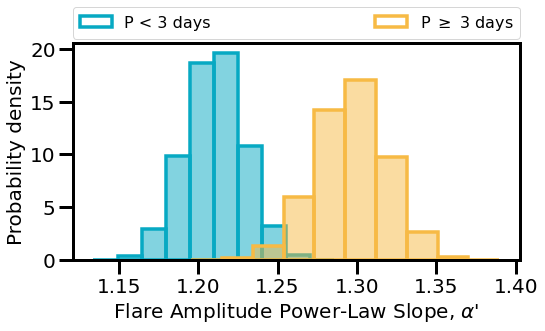

In [45]:
# Plot histogram of slopes
plt.figure(figsize=(8,4))

c1=100
c2=210

plt.hist(samples_short[:,0], density=True, 
         color=parula[c1],alpha=0.5)
plt.hist(samples_short[:,0], density=True, label='P < 3 days',
         edgecolor=parula[c1],histtype='bar',fill=None,lw=3.5)

plt.hist(samples_long[:,0], density=True, 
        color=parula[c2],alpha=0.5)
plt.hist(samples_long[:,0], density=True, label='P $\geq$ 3 days',
        edgecolor=parula[c2],histtype='bar',fill=None,lw=3.5)


plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0., fontsize=16)
plt.xlabel(r"Flare Amplitude Power-Law Slope, $\alpha$'")
plt.ylabel(r'Probability density')
plt.savefig('/Users/arcticfox/Desktop/hist.pdf')